In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import desc
from pyspark.sql.functions import asc
from pyspark.sql.functions import sum as Fsum
from pyspark.sql import Window

from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import pandas as pd

In [2]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Capstone") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
user_log = spark.read.json("mini_sparkify_event_data.json")
user_log.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [4]:
user_log.take(1)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')]

In [5]:
print('Number of events: ',user_log.count())

Number of events:  286500


In [6]:
print('Number of events whithout a user id: ', user_log.where(col('userid').isNull() | (col('userid') == '')).count())

Number of events whithout a user id:  8346


In [7]:
user_log = user_log.where(col('userid').isNotNull() & (col('userid') != ''))
print('Number of events whith a user id: ',user_log.count())

Number of events whith a user id:  278154


# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

Users in the dataset

In [8]:
user_log.select("userid").dropDuplicates().describe().show()

+-------+------------------+
|summary|            userid|
+-------+------------------+
|  count|               225|
|   mean|65391.013333333336|
| stddev|105396.47791907164|
|    min|                10|
|    max|                99|
+-------+------------------+



Pages that an user can visit

In [9]:
user_log.select("page").dropDuplicates().sort("page").show()

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|              Logout|
|            NextSong|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
|      Submit Upgrade|
|         Thumbs Down|
|           Thumbs Up|
|             Upgrade|
+--------------------+



Authentication states and subscription levels

In [10]:
user_log.select("auth","level").dropDuplicates().sort("auth").show()

+---------+-----+
|     auth|level|
+---------+-----+
|Cancelled| free|
|Cancelled| paid|
|Logged In| free|
|Logged In| paid|
+---------+-----+



Web pages, http methods and response codes

In [11]:
user_log.select("status", "method", "page").sort("page").dropDuplicates().show()

+------+------+--------------------+
|status|method|                page|
+------+------+--------------------+
|   200|   GET|               About|
|   307|   PUT|          Add Friend|
|   200|   PUT|     Add to Playlist|
|   307|   PUT|              Cancel|
|   200|   GET|Cancellation Conf...|
|   200|   GET|           Downgrade|
|   404|   GET|               Error|
|   200|   GET|                Help|
|   200|   GET|                Home|
|   307|   PUT|              Logout|
|   200|   PUT|            NextSong|
|   200|   GET|         Roll Advert|
|   307|   PUT|       Save Settings|
|   200|   GET|            Settings|
|   307|   PUT|    Submit Downgrade|
|   307|   PUT|      Submit Upgrade|
|   307|   PUT|         Thumbs Down|
|   307|   PUT|           Thumbs Up|
|   200|   GET|             Upgrade|
+------+------+--------------------+



### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

In [12]:
count = user_log.where((col('page') == 'Cancellation Confirmation')  & (col('status') == '200')).count()
print('{} users had their accounts cancelled'.format(count))

52 users had their accounts cancelled


In [13]:
count = user_log.where((col('page') == 'Downgrade') & (col('status') == '200')).count()
print('{} times the Dowgrade page was opened'.format(count))

2055 times the Dowgrade page was opened


In [14]:
count = user_log.where((col('page') == 'Submit Downgrade') & (col('status') == '307')).count()
print('{} times an account was actually downgraded'.format(count))

63 times an account was actually downgraded


In [15]:
count = user_log.where((col('page') == 'Upgrade') & (col('status') == '200')).count()
print('{} times the upgrade page was opened'.format(count))

499 times the upgrade page was opened


In [16]:
count = user_log.where((col('page') == 'Submit Upgrade') & (col('status') == '307')).count()
print('{} times an account was upgraded'.format(count))

159 times an account was upgraded


In [17]:
cancellation_confirmation_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
downgrade_event = udf(lambda x: 1 if x == "Downgrade" else 0, IntegerType())

user_log = user_log.withColumn("churn", cancellation_confirmation_event("page"))
user_log = user_log.withColumn("downgraded", downgrade_event("page"))

In [18]:
user_log.where((col('page') == 'Cancellation Confirmation')).take(2)

[Row(artist=None, auth='Cancelled', firstName='Adriel', gender='M', itemInSession=104, lastName='Mendoza', length=None, level='paid', location='Kansas City, MO-KS', method='GET', page='Cancellation Confirmation', registration=1535623466000, sessionId=514, song=None, status=200, ts=1538943990000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.77.4 (KHTML, like Gecko) Version/7.0.5 Safari/537.77.4"', userId='18', churn=1, downgraded=0),
 Row(artist=None, auth='Cancelled', firstName='Diego', gender='M', itemInSession=56, lastName='Mckee', length=None, level='paid', location='Phoenix-Mesa-Scottsdale, AZ', method='GET', page='Cancellation Confirmation', registration=1537167593000, sessionId=540, song=None, status=200, ts=1539033046000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='32', churn=1, downgraded=0)]

In [19]:
user_log.where((col('page') == 'Submit Downgrade')).take(2)

[Row(artist=None, auth='Logged In', firstName='Kael', gender='M', itemInSession=47, lastName='Baker', length=None, level='paid', location='Kingsport-Bristol-Bristol, TN-VA', method='PUT', page='Submit Downgrade', registration=1533102330000, sessionId=249, song=None, status=307, ts=1538393619000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.77.4 (KHTML, like Gecko) Version/7.0.5 Safari/537.77.4"', userId='131', churn=0, downgraded=0),
 Row(artist=None, auth='Logged In', firstName='Calvin', gender='M', itemInSession=17, lastName='Marshall', length=None, level='paid', location='Pittsburgh, PA', method='PUT', page='Submit Downgrade', registration=1537120757000, sessionId=313, song=None, status=307, ts=1538516445000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.78.2 (KHTML, like Gecko) Version/7.0.6 Safari/537.78.2"', userId='38', churn=0, downgraded=0)]

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [20]:
user_window = Window.partitionBy("userId").orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding, 0)
user_log = user_log.withColumn("phase", Fsum("downgraded").over(user_window))

Sample of a user that cancelled her account

In [21]:
user_log.select(["userId", "ts", "page", "level", "phase"]).where(user_log.userId == "100014").sort(col("ts").desc()).take(5)

[Row(userId='100014', ts=1542740649000, page='Cancellation Confirmation', level='paid', phase=0),
 Row(userId='100014', ts=1542740642000, page='Cancel', level='paid', phase=0),
 Row(userId='100014', ts=1542740641000, page='Downgrade', level='paid', phase=1),
 Row(userId='100014', ts=1542740628000, page='NextSong', level='paid', phase=1),
 Row(userId='100014', ts=1542740352000, page='NextSong', level='paid', phase=1)]

Amount of users by subscription level

In [22]:
churned_users = user_log.where(col('churn') == '1').select('userId', 'level')
churned_users.groupby('level').count().show()

+-----+-----+
|level|count|
+-----+-----+
| free|   21|
| paid|   31|
+-----+-----+



Pages visited by users before cancelling:

In [23]:
tempRDD = user_log.sort('userId','ts')\
            .select('userId','page')\
            .rdd.reduceByKey(lambda x,y: x + ',' + y if (y == 'Cancellation Confirmation' or y == 'Cancel') else y)

last_page = tempRDD.toDF(['userId', 'page'])\
                .where(col('page').like('%Confirmation'))\
                .withColumn('page', split(col('page'),','))\
                .withColumn('page', array_remove(col('page'), 'Cancel'))\
                .withColumn('page', array_remove(col('page'), 'Cancellation Confirmation'))\
                .withColumn('page', array_join(col('page'), ''))

In [24]:
churn_count = user_log.where(col('churn') == '1').count()
last_page_df = last_page.groupBy('page').count().withColumn('percentage', 100 * col('count')/churn_count)
last_page_df.show()

+-----------+-----+------------------+
|       page|count|        percentage|
+-----------+-----+------------------+
|Thumbs Down|    4|7.6923076923076925|
|  Downgrade|   20| 38.46153846153846|
|Roll Advert|   14|26.923076923076923|
|   Settings|   14|26.923076923076923|
+-----------+-----+------------------+



In [25]:
ax = last_page_df.toPandas().plot.pie(y='percentage')
ax.legend(["Thumbds Down", "Downgrade", "Roll Advert", "Settings"]);

If we do a count we see that paid users are getting ads

In [26]:
paid_advert_count = user_log.where((col('level') == 'paid') & (col('page') == 'Roll Advert')).count()
print('{} times a paid user got an ad'.format(paid_advert_count))

246 times a paid user got an ad


In average users that churned perform the following actions

In [27]:
ta = user_log.alias('ta')
tb = churned_users.alias('tb')

churn_page_avg = ta.join(tb, tb.userId == ta.userId, how='leftsemi')\
                    .select('ta.userId','page')\
                    .groupBy('ta.userId','page').count()\
                    .groupBy('page').avg()\
                    .sort('page')
churn_page_avg.show()

+--------------------+------------------+
|                page|        avg(count)|
+--------------------+------------------+
|               About|1.8064516129032258|
|          Add Friend|14.454545454545455|
|     Add to Playlist|             20.76|
|              Cancel|               1.0|
|Cancellation Conf...|               1.0|
|           Downgrade| 9.628571428571428|
|               Error|1.4545454545454546|
|                Help| 5.558139534883721|
|                Home| 32.78431372549019|
|              Logout|12.021739130434783|
|            NextSong| 699.8846153846154|
|         Roll Advert|             19.34|
|       Save Settings|1.9333333333333333|
|            Settings|  6.27906976744186|
|    Submit Downgrade|               1.0|
|      Submit Upgrade| 1.103448275862069|
|         Thumbs Down|10.333333333333334|
|           Thumbs Up|             37.18|
|             Upgrade| 3.027027027027027|
+--------------------+------------------+



In average users that didn't churn perform the following actions

In [28]:
ta = user_log.alias('ta')
tb = churned_users.alias('tb')

not_churn_page_avg = ta.join(tb, tb.userId == ta.userId, how='leftanti')\
                        .select('ta.userId','page')\
                        .groupBy('ta.userId','page').count()\
                        .groupBy('page').avg()\
                        .sort('page')
not_churn_page_avg.show()

+----------------+------------------+
|            page|        avg(count)|
+----------------+------------------+
|           About|3.5403225806451615|
|      Add Friend| 22.47530864197531|
| Add to Playlist| 33.26060606060606|
|       Downgrade|14.436974789915967|
|           Error|2.3157894736842106|
|            Help| 8.154362416107382|
|            Home|48.895348837209305|
|          Logout|16.005988023952096|
|        NextSong|1108.1734104046243|
|     Roll Advert| 18.89171974522293|
|   Save Settings|2.4705882352941178|
|        Settings|  8.18421052631579|
|Submit Downgrade|              1.35|
|  Submit Upgrade|1.2450980392156863|
|     Thumbs Down|13.225806451612904|
|       Thumbs Up| 62.89411764705882|
|         Upgrade| 2.954198473282443|
+----------------+------------------+



It doesn't matter if an user cancells their account or not. They visit the same pages.

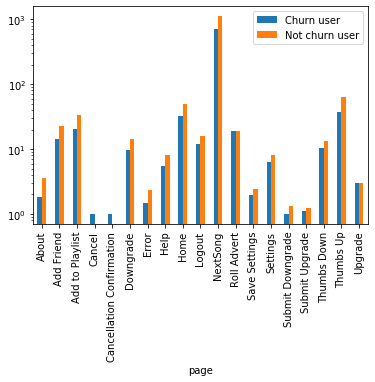

In [29]:
df = pd.merge(churn_page_avg.toPandas(), not_churn_page_avg.toPandas(), on='page', how='outer')
ax = df.plot.bar(x='page', logy=True)
ax.legend(["Churn user", "Not churn user"]);

There are users that go to the Downgrade page without submiting the downgrade. Even users that have downgraded and upgraded again do that.

In [30]:
user_log.select(["userId", "ts", "page", "level", "phase"]).where(user_log.userId == "100014").sort(col("ts").desc()).take(5)

[Row(userId='100014', ts=1542740649000, page='Cancellation Confirmation', level='paid', phase=0),
 Row(userId='100014', ts=1542740642000, page='Cancel', level='paid', phase=0),
 Row(userId='100014', ts=1542740641000, page='Downgrade', level='paid', phase=1),
 Row(userId='100014', ts=1542740628000, page='NextSong', level='paid', phase=1),
 Row(userId='100014', ts=1542740352000, page='NextSong', level='paid', phase=1)]

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

0. Prepare the datasets (same as above)

In [31]:
user_log = spark.read.json("mini_sparkify_event_data.json")
user_log = user_log.where(col('userid').isNotNull() & (col('userid') != ''))
cancellation_confirmation_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
user_log = user_log.withColumn("churn", cancellation_confirmation_event("page"))
churned_users = user_log.where(col('churn') == '1').select('userId', 'level')

1. Create user base, one column for each page with the times a user opened it

In [32]:
user_events_count = user_log.groupBy('userid','page').count()
user_events_count_pivoted = user_events_count.groupBy('userId')\
                                .pivot('page').agg(first(col('count').cast('int')))\
                                .drop('Cancel', 'Cancellation Confirmation')\
                                .na.fill(0)


In [33]:
user_events_count_pivoted.printSchema()

root
 |-- userId: string (nullable = true)
 |-- About: integer (nullable = true)
 |-- Add Friend: integer (nullable = true)
 |-- Add to Playlist: integer (nullable = true)
 |-- Downgrade: integer (nullable = true)
 |-- Error: integer (nullable = true)
 |-- Help: integer (nullable = true)
 |-- Home: integer (nullable = true)
 |-- Logout: integer (nullable = true)
 |-- NextSong: integer (nullable = true)
 |-- Roll Advert: integer (nullable = true)
 |-- Save Settings: integer (nullable = true)
 |-- Settings: integer (nullable = true)
 |-- Submit Downgrade: integer (nullable = true)
 |-- Submit Upgrade: integer (nullable = true)
 |-- Thumbs Down: integer (nullable = true)
 |-- Thumbs Up: integer (nullable = true)
 |-- Upgrade: integer (nullable = true)



2. Add a churn column

In [34]:
ta = user_log.select('userId','page','level').dropDuplicates(['userId'])

churn_user_base = ta.join(churned_users, 'userId', how='leftsemi')\
                        .withColumn('churn', lit(1))

not_churn_user_base = ta.join(churned_users, 'userId', how='leftanti')\
                            .withColumn('churn', lit(0))

user_base = churn_user_base.union(not_churn_user_base)\
                        .join(user_events_count_pivoted, 'userId')

In [35]:
churn_user_base.printSchema()

root
 |-- userId: string (nullable = true)
 |-- page: string (nullable = true)
 |-- level: string (nullable = true)
 |-- churn: integer (nullable = false)



3. One hot encode the last action performed

In [36]:
last_page = user_log.sort('userId','ts')\
            .select('userId','page')\
            .rdd.reduceByKey(lambda x,y: x if (y == 'Cancellation Confirmation' or y == 'Cancel') else y)\
            .toDF(['userId', 'page'])

In [37]:
one_hot_encoded = last_page
pages = last_page.select('page')\
                .distinct()\
                .rdd.flatMap(lambda x : x).collect()
pages.sort()

for page in pages:
    function = udf(lambda item: 1 if item == page else 0, IntegerType())
    new_column_name = 'last_page_'+page
    one_hot_encoded = one_hot_encoded.withColumn(new_column_name, function(col('page')))
    
one_hot_encoded = one_hot_encoded.drop('page')
user_base = user_base.drop('page').join(one_hot_encoded, 'userId', how='left')
user_base = user_base.na.fill(0)

In [38]:
one_hot_encoded.printSchema()

root
 |-- userId: string (nullable = true)
 |-- last_page_About: integer (nullable = true)
 |-- last_page_Add Friend: integer (nullable = true)
 |-- last_page_Add to Playlist: integer (nullable = true)
 |-- last_page_Downgrade: integer (nullable = true)
 |-- last_page_Help: integer (nullable = true)
 |-- last_page_Home: integer (nullable = true)
 |-- last_page_Logout: integer (nullable = true)
 |-- last_page_NextSong: integer (nullable = true)
 |-- last_page_Roll Advert: integer (nullable = true)
 |-- last_page_Settings: integer (nullable = true)
 |-- last_page_Thumbs Down: integer (nullable = true)
 |-- last_page_Thumbs Up: integer (nullable = true)



4. Last level

In [39]:
last_level = user_log.sort('userId','ts')\
            .select('userId','level')\
            .rdd.reduceByKey(lambda x,y: y)\
            .toDF(['userId', 'level'])

In [40]:
one_hot_encoded = last_level
levels = user_base.select('level')\
                .distinct()\
                .rdd.flatMap(lambda x : x).collect()
levels.sort()

for level in levels:
    function = udf(lambda item: 1 if item == level else 0, IntegerType())
    new_column_name = 'last_level_'+level
    one_hot_encoded = one_hot_encoded.withColumn(new_column_name, function(col('level')))
    
one_hot_encoded = one_hot_encoded.drop('level')
user_base = user_base.join(one_hot_encoded, 'userId', how='left')
user_base = user_base.na.fill(0)

In [41]:
one_hot_encoded.printSchema()

root
 |-- userId: string (nullable = true)
 |-- last_level_free: integer (nullable = true)
 |-- last_level_paid: integer (nullable = true)



Final schema

In [42]:
user_base.printSchema()

root
 |-- userId: string (nullable = true)
 |-- level: string (nullable = true)
 |-- churn: integer (nullable = false)
 |-- About: integer (nullable = true)
 |-- Add Friend: integer (nullable = true)
 |-- Add to Playlist: integer (nullable = true)
 |-- Downgrade: integer (nullable = true)
 |-- Error: integer (nullable = true)
 |-- Help: integer (nullable = true)
 |-- Home: integer (nullable = true)
 |-- Logout: integer (nullable = true)
 |-- NextSong: integer (nullable = true)
 |-- Roll Advert: integer (nullable = true)
 |-- Save Settings: integer (nullable = true)
 |-- Settings: integer (nullable = true)
 |-- Submit Downgrade: integer (nullable = true)
 |-- Submit Upgrade: integer (nullable = true)
 |-- Thumbs Down: integer (nullable = true)
 |-- Thumbs Up: integer (nullable = true)
 |-- Upgrade: integer (nullable = true)
 |-- last_page_About: integer (nullable = true)
 |-- last_page_Add Friend: integer (nullable = true)
 |-- last_page_Add to Playlist: integer (nullable = true)
 |-- l

In [43]:
user_base.toPandas().head()

,userId,level,churn,About,Add Friend,Add to Playlist,Downgrade,Error,Help,Home,...,last_page_Help,last_page_Home,last_page_Logout,last_page_NextSong,last_page_Roll Advert,last_page_Settings,last_page_Thumbs Down,last_page_Thumbs Up,last_level_free,last_level_paid
0,100010,free,0,1,4,7,0,0,2,11,...,0,0,1,0,0,0,0,0,1,0
1,200002,free,0,3,4,8,5,0,2,20,...,0,0,0,0,0,0,0,1,0,1
2,125,free,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
3,124,paid,0,7,74,118,41,6,23,176,...,0,1,0,0,0,0,0,0,0,1
4,51,paid,1,2,28,52,23,1,12,75,...,0,0,0,0,0,1,0,0,0,1


# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

0. Prepare the dataset for training

In [44]:
vector_assembler = VectorAssembler(inputCols=["About", "Add Friend", "Add to Playlist", "Downgrade", "Error", "Help", "Home", "Logout", "NextSong", "Roll Advert", "Save Settings", "Settings", "Submit Downgrade", "Submit Upgrade", "Thumbs Up", "Thumbs Down", "Upgrade", "last_page_About", "last_page_Add Friend", "last_page_Add to Playlist", "last_page_Downgrade", "last_page_Help", "last_page_Home", "last_page_Logout", "last_page_NextSong", "last_page_Roll Advert", "last_page_Settings", "last_page_Thumbs Down", "last_page_Thumbs Up", "last_level_free", "last_level_paid"],outputCol="features")

df_temp = vector_assembler.transform(user_base)
df_temp = df_temp.drop("About", "Add Friend", "Add to Playlist", "Downgrade", "Error", "Help", "Home", "Logout", "NextSong", "Roll Advert", "Save Settings", "Settings", "Submit Downgrade", "Submit Upgrade", "Thumbs Up", "Thumbs Down", "Upgrade", "last_page_About", "last_page_Add Friend", "last_page_Add to Playlist", "last_page_Downgrade", "last_page_Help", "last_page_Home", "last_page_Logout", "last_page_NextSong", "last_page_Roll Advert", "last_page_Settings", "last_page_Thumbs Down", "last_page_Thumbs Up", "last_level_free", "last_level_paid")

df_temp.take(1)

[Row(userId='100010', level='free', churn=0, features=SparseVector(31, {0: 1.0, 1: 4.0, 2: 7.0, 5: 2.0, 6: 11.0, 7: 5.0, 8: 275.0, 9: 52.0, 14: 17.0, 15: 5.0, 16: 2.0, 23: 1.0, 29: 1.0}))]

1. Build a Decision Tree classifier, and a Cross Validator to test different parameters

In [45]:
train, test = df_temp.withColumnRenamed('churn', 'label').randomSplit([0.7, 0.3], seed=42)
model = DecisionTreeClassifier(featuresCol="features")

paramGrid = ParamGridBuilder() \
    .addGrid(model.maxDepth,[5, 10, 30]) \
    .addGrid(model.maxBins,[32, 64]) \
    .build()

crossval = CrossValidator(estimator=model,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)

cv_model = crossval.fit(train)

3. Measure the final predictions over the testing set

In [46]:
predictions = cv_model.transform(test)
predictions.select("prediction", "label").show(5)

+----------+-----+
|prediction|label|
+----------+-----+
|       0.0|    0|
|       1.0|    1|
|       0.0|    0|
|       1.0|    1|
|       0.0|    0|
+----------+-----+
only showing top 5 rows



In [62]:
evaluatorMulti = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction",metricName="accuracy")
predictionAndTarget = predictions.select("prediction", "label")

# Get metrics
acc = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "accuracy"})
f1 = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "f1"})
weightedPrecision = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "weightedPrecision"})
weightedRecall = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "weightedRecall"})
print("Accuracy = %g " % accuracy)
print("F1 score = %g " % f1)
print("Weighted Precision = %g " % weightedPrecision)
print("Weighted Recall = %g " % weightedRecall)



Accuracy = 0.919355 
F1 score = 0.918488 
Weighted Precision = 0.918234 
Weighted Recall = 0.919355 


The final model has the following parameters

In [49]:
bestModel = cv_model.bestModel
print('Best Param (maxDepth): ', bestModel._java_obj.getMaxDepth())
print('Best Param (maxBins): ', bestModel._java_obj.getMaxBins())

Best Param (maxDepth):  5
Best Param (maxBins):  32


# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.